In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [23]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [3]:
raw_data = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv"
)

<IPython.core.display.Javascript object>

In [4]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

<IPython.core.display.Javascript object>

In [5]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

<IPython.core.display.Javascript object>

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

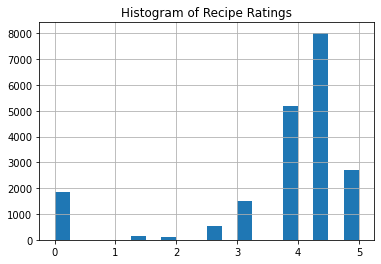

<IPython.core.display.Javascript object>

In [6]:
raw_data.rating.hist(bins=20)
plt.title("Histogram of Recipe Ratings")
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [7]:
# Count nulls
null_count = raw_data.isnull().sum()
null_count[null_count > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

<IPython.core.display.Javascript object>

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [8]:
svr = SVR()
X = raw_data.drop(
    ["rating", "title", "calories", "protein", "fat", "sodium"], 1
).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X, Y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

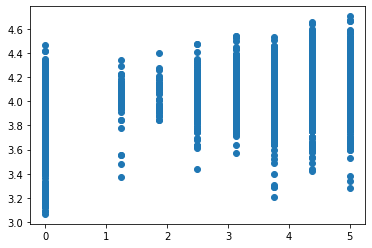

<IPython.core.display.Javascript object>

In [9]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinuous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [10]:
svr.score(X, Y)

-0.003978314483867873

<IPython.core.display.Javascript object>

In [14]:
cross_val_score(svr, X, Y, cv=5)

array([-0.01787926, -0.02916288, -0.02841122, -0.03767394, -0.01735362])

<IPython.core.display.Javascript object>

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

In [15]:
# turning rating into a binary variable:
# 0 for low and 1 for high.

ratings = raw_data["rating"]

med_rating = np.median(ratings)

new_ratings = []

for rating in ratings:
    if rating < med_rating:
        new_ratings.append(0)
    else:
        new_ratings.append(1)

raw_data["rating"] = new_ratings

<IPython.core.display.Javascript object>

In [16]:
#checking to make sure it worked
raw_data["rating"].value_counts()

1    10738
0     9314
Name: rating, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
# feature selection
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(678), int64(1), object(1)
memory usage: 104.0+ MB


<IPython.core.display.Javascript object>

In [59]:
# throwing everything into the svm and then selecting the
# most valuable features might be the easiest approach
X = raw_data.drop(
    ["rating", "title", "calories", "protein", "fat", "sodium"], 1
).sample(frac=0.3, replace=True, random_state=1)


X = raw_data.drop(columns=["rating", "title", "calories", "protein", "fat", "sodium"])
y = raw_data["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

<IPython.core.display.Javascript object>

In [32]:
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

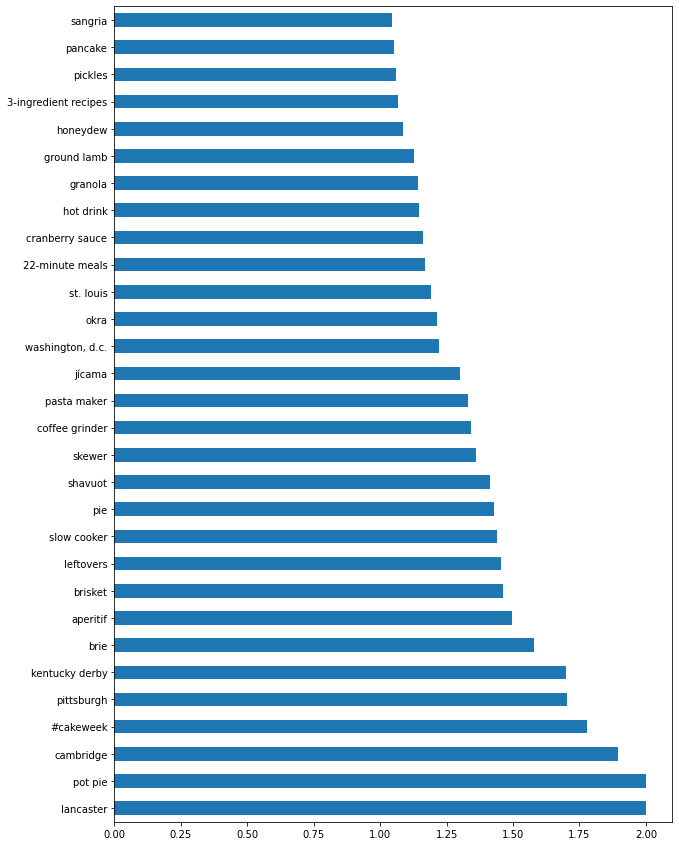

<IPython.core.display.Javascript object>

In [61]:
plt.figure(figsize=(10, 15))
pd.Series(abs(svc.coef_[0]), index=X.columns).nlargest(30).plot(kind="barh")

In [37]:
train_score = svc.score(X_train, y_train)
test_score = svc.score(X_test, y_test)

print(f"Train score: {train_score:.2f}")
print(f"Test score: {test_score:.2f}")

Train score: 0.64
Test score: 0.60


<IPython.core.display.Javascript object>

In [66]:
keep_cols = list(pd.Series(abs(svc.coef_[0]), index=X.columns).nlargest(30).index)
print(keep_cols)

['lancaster', 'pot pie', 'cambridge', '#cakeweek', 'pittsburgh', 'kentucky derby', 'brie', 'aperitif', 'brisket', 'leftovers', 'slow cooker', 'pie', 'shavuot', 'skewer', 'coffee grinder', 'pasta maker', 'jícama', 'washington, d.c.', 'okra', 'st. louis', '22-minute meals', 'cranberry sauce', 'hot drink', 'granola', 'ground lamb', 'honeydew', '3-ingredient recipes', 'pickles', 'pancake', 'sangria']


<IPython.core.display.Javascript object>

In [68]:
X = raw_data[keep_cols]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

svc_2 = SVC()
svc_2.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

In [70]:
train_score = svc_2.score(X_train, y_train)
test_score = svc_2.score(X_test, y_test)

print(f"Train score: {train_score:.2f}")
print(f"Test score: {test_score:.2f}")

Train score: 0.54
Test score: 0.54


<IPython.core.display.Javascript object>

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.